In [3]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score

In [2]:
import pandas as pd
# data01 라벨인코딩
trn_data = pd.read_csv('./data/trn_data01')
tst_data = pd.read_csv('./data/tst_data01')

In [6]:
trn_data.groupby('class').sum()

C:\Users\deepBlue\AppData\Local\Temp\ipykernel_4252\4217489923.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trn_data.groupby('class').sum()


,father,mother,gender,trait,SNP_01_Enc,SNP_02_Enc,SNP_03_Enc,SNP_04_Enc,SNP_05_Enc,SNP_06_Enc,SNP_07_Enc,SNP_08_Enc,SNP_09_Enc,SNP_10_Enc,SNP_11_Enc,SNP_12_Enc,SNP_13_Enc,SNP_14_Enc,SNP_15_Enc
class,,,,,,,,,,,,,,,,,,,
A,0,0,0,69,27,132,0,103,14,118,120,11,79,40,125,116,135,79,109
B,0,0,0,228,203,132,121,79,179,101,9,171,24,224,103,40,89,0,46
C,0,0,0,158,123,49,67,9,57,61,21,72,1,106,34,23,101,21,55


In [7]:
def cat_to_num(df):
    df['class'] = df['class'].replace({'A':0,'B':1,'C':2})
    return df

In [8]:
def num_to_cat(df):
    df['class'] = df['class'].replace({0:'A',1:'B',2:'C'})
    return df

In [12]:
trn_data = cat_to_num(trn_data)

In [13]:
features = trn_data.drop(['id', 'class',],axis=1)
labels = trn_data['class']
X_train, X_test, y_train, y_test=train_test_split(features,labels,test_size=0.3,random_state=42)

In [16]:
# features.info()

In [21]:
import numpy as np
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    data, target = features,labels
    train_x, valid_x, train_y, valid_y = train_test_split(features,labels, test_size=0.3)

    param = {
        # 'loss_function':'MultiClass',
        "objective": trial.suggest_categorical("objective", ["MultiClass"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),        
        "depth": trial.suggest_int("depth", 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

### caution
- max depth를 12 이상으로 주지 않는 것이 좋은 이유
The default tree growing strategy in catboost is symmetric trees. If you set depth to 16, then every tree will have 2^16 leaves, which is probably not what you want. It is recommended to use depth up to 10 or 12.

    - [catboost pararmeter training](https://catboost.ai/en/docs/concepts/parameter-tuning)

###
1. 캐글 코드 참고
    - https://www.kaggle.com/code/georgyzubkov/spaceship-eda-catboost-with-optuna
2. 설명 블로그 참고
    - https://ssoonidev.tistory.com/107
3. catboost 주요 개념
    - https://dailyheumsi.tistory.com/136

In [22]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-12 22:01:57,035] A new study created in memory with name: no-name-6b915b75-e5f1-493a-9de4-c1456a465075
[I 2022-12-12 22:01:57,464] Trial 0 finished with value: 0.8987341772151899 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.07821515739422562, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8139867017417161}. Best is trial 0 with value: 0.8987341772151899.
[I 2022-12-12 22:01:57,851] Trial 1 finished with value: 0.9367088607594937 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09872521727507955, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.9367088607594937.
[I 2022-12-12 22:01:58,064] Trial 2 finished with value: 0.9367088607594937 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.059044671536851195, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.9367088607594937.
[I 2022-12-12 22

Number of finished trials: 100
Best trial:
  Value: 0.9873417721518988
  Params: 
    objective: MultiClass
    colsample_bylevel: 0.04812658296898649
    depth: 11
    boosting_type: Ordered
    bootstrap_type: MVS


In [23]:
from optuna import visualization
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
hist = study.trials_dataframe()
hist.head()

Best trial: score 0.9873417721518988,
params {'objective': 'MultiClass', 'colsample_bylevel': 0.04812658296898649, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}


,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_colsample_bylevel,params_depth,params_objective,params_subsample,state
0,0,0.898734,2022-12-12 22:01:57.036800,2022-12-12 22:01:57.464409,0 days 00:00:00.427609,NaN,Ordered,Bernoulli,0.078215,11,MultiClass,0.813987,COMPLETE
1,1,0.936709,2022-12-12 22:01:57.465409,2022-12-12 22:01:57.851886,0 days 00:00:00.386477,NaN,Ordered,MVS,0.098725,7,MultiClass,NaN,COMPLETE
2,2,0.936709,2022-12-12 22:01:57.852889,2022-12-12 22:01:58.064372,0 days 00:00:00.211483,NaN,Ordered,MVS,0.059045,10,MultiClass,NaN,COMPLETE
3,3,0.974684,2022-12-12 22:01:58.065375,2022-12-12 22:01:58.324211,0 days 00:00:00.258836,0.816923,Plain,Bayesian,0.077140,8,MultiClass,NaN,COMPLETE
4,4,0.949367,2022-12-12 22:01:58.325534,2022-12-12 22:01:58.490702,0 days 00:00:00.165168,NaN,Plain,MVS,0.041537,6,MultiClass,NaN,COMPLETE


In [14]:
# optuna.visualization.plot_slice(study)

In [15]:
# optuna.visualization.plot_optimization_history(study)

In [16]:
# optuna.visualization.plot_param_importances(study)

In [17]:
# y_train = y_train.replace({False:0,True:1})

In [24]:
# 그리드서치로 재훈련
# 'objective': 'MultiClass', 'colsample_bylevel': 0.04812658296898649, 'depth': 11, 
# 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'
clf=CatBoostClassifier()
parametres={'objective': ['MultiClass'], 'colsample_bylevel': [0.04812658296898649], 
'depth': [11],'boosting_type': ['Ordered'], 'bootstrap_type': ['MVS'],}
grid_search_cv_clf=GridSearchCV(clf,parametres,cv=5)
grid_search_cv_clf.fit(X_train,y_train)
best_clf2=grid_search_cv_clf.best_estimator_
y_pred2=best_clf2.predict(X_test)
print(f'Accuracy_score: {accuracy_score(y_test,y_pred2)}')

Learning rate set to 0.071731
0:	learn: 1.0939761	total: 311us	remaining: 311ms
1:	learn: 1.0899955	total: 577us	remaining: 288ms
2:	learn: 1.0565856	total: 845us	remaining: 281ms
3:	learn: 1.0536543	total: 1.07ms	remaining: 267ms
4:	learn: 1.0348876	total: 1.33ms	remaining: 266ms
5:	learn: 0.9864705	total: 1.67ms	remaining: 276ms
6:	learn: 0.9650382	total: 1.94ms	remaining: 275ms
7:	learn: 0.9633401	total: 2.15ms	remaining: 267ms
8:	learn: 0.9260897	total: 2.6ms	remaining: 286ms
9:	learn: 0.8876898	total: 3.76ms	remaining: 372ms
10:	learn: 0.8862939	total: 4.01ms	remaining: 361ms
11:	learn: 0.8850859	total: 4.26ms	remaining: 351ms
12:	learn: 0.8840400	total: 4.47ms	remaining: 339ms
13:	learn: 0.8493489	total: 4.79ms	remaining: 337ms
14:	learn: 0.8485571	total: 5.03ms	remaining: 330ms
15:	learn: 0.8478709	total: 5.3ms	remaining: 326ms
16:	learn: 0.8472760	total: 5.55ms	remaining: 321ms
17:	learn: 0.8264749	total: 5.86ms	remaining: 320ms
18:	learn: 0.8260377	total: 6.11ms	remaining: 315

In [20]:
# 모델 저장
# import joblib
# model_path = './' + 'model/' + 'optunaCATnew01' +'.model'
# # model.save_model(model_path)
# joblib.dump(best_clf2, open(model_path, 'wb'))

Text(0.5, 1.0, 'Feature Importance')

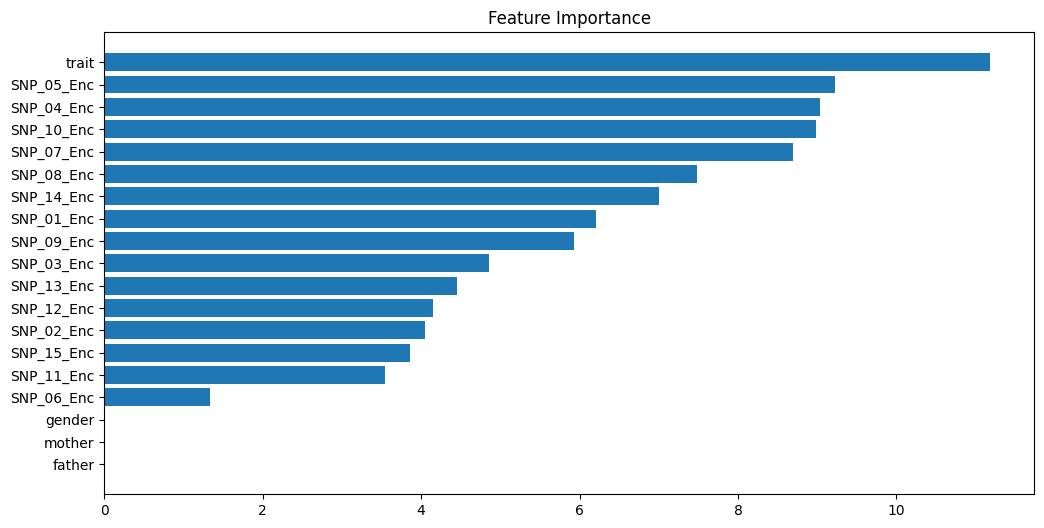

In [25]:
import matplotlib.pyplot as plt

feature_importance = best_clf2.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


In [27]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
# roc_auc= auc(fpr, tpr)
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange',
#           label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [31]:
tst_data.columns

Index(['id', 'father', 'mother', 'gender', 'trait', 'SNP_01_Enc', 'SNP_02_Enc',
       'SNP_03_Enc', 'SNP_04_Enc', 'SNP_05_Enc', 'SNP_06_Enc', 'SNP_07_Enc',
       'SNP_08_Enc', 'SNP_09_Enc', 'SNP_10_Enc', 'SNP_11_Enc', 'SNP_12_Enc',
       'SNP_13_Enc', 'SNP_14_Enc', 'SNP_15_Enc'],
      dtype='object')

In [23]:
# test_update = pd.read_csv('./kaggle/input/spaceship-titanic/test_AgeGroup_update.csv')
test01 = tst_data.drop(['id', ],axis=1)
y_predicted=best_clf2.predict(test01)

In [24]:
submissions = pd.concat([test_update.PassengerId,pd.Series(y_predicted).map(bool)],axis=1)
submissions=submissions.rename(columns={0:'Transported'})


# submissions.to_csv('submissionCAT02.csv',index=False)

In [27]:
sub = pd.read_csv('./kaggle/input/spaceship-titanic/sample_submission.csv')
sub = sub.drop(['Transported'],axis=1)
df_sub = pd.merge(sub, submissions, how='outer', on = 'PassengerId')

In [29]:
df_sub.to_csv('submissionCAT03.csv',index=False)

In [66]:
# pred = model.predict(test_update.drop(['Transported','testset','Name','PassengerId'],axis=1))